# Lecture 18의 데모

### Lecture 18의 데모에 대한 코드

참고자료: 

https://github.com/data-8/materials-sp22/blob/main/lec/lec33.ipynb


In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/ITEC419-fa22/lec

Mounted at /content/gdrive
/content/gdrive/MyDrive/ITEC419-fa22/lec


In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    """Return an array of all the residuals"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

## **Regression Model**

In [6]:
# Ignore this code; it's graphics for demonstrating the regression model
def draw_and_compare(true_slope, true_int, sample_size):
  # 점을 임의로 찍음
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    # 원래 데이터가 Line에서 출발, 여기에서 error을 더한 데이터 만듬
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

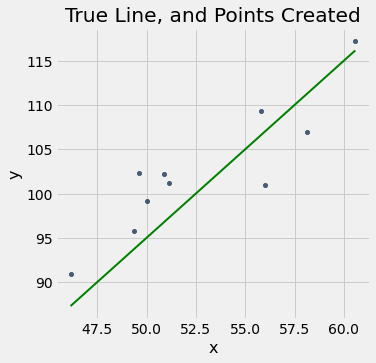

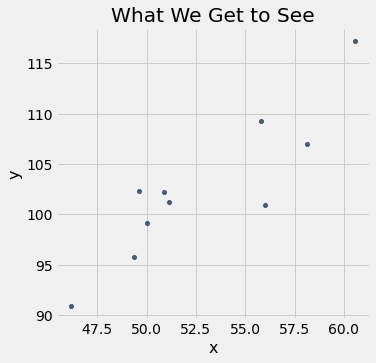

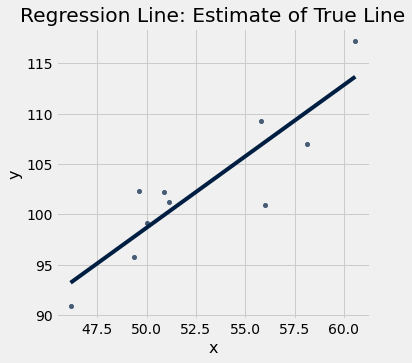

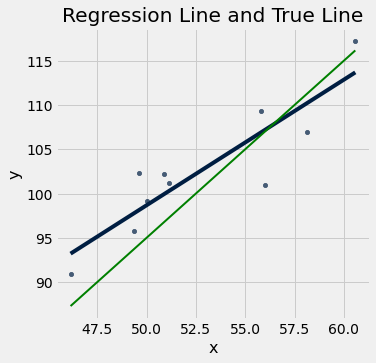

In [8]:
# 원래 데이터에 따른 Line과
# noise에 맞춰 fitting한 line 다를 수 있음
draw_and_compare(2, -5, 10)

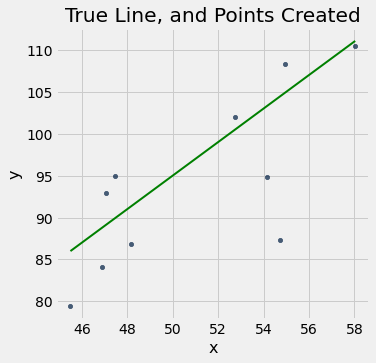

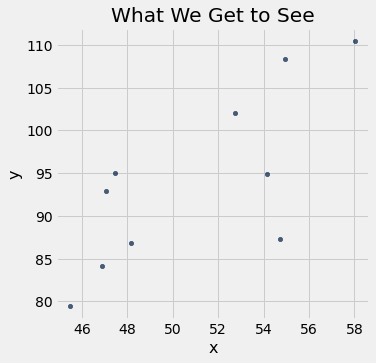

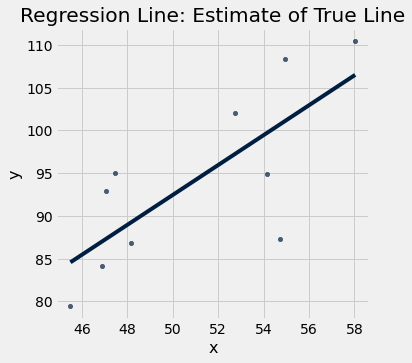

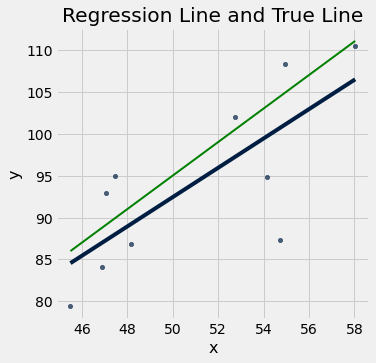

In [9]:
draw_and_compare(2, -5, 10)

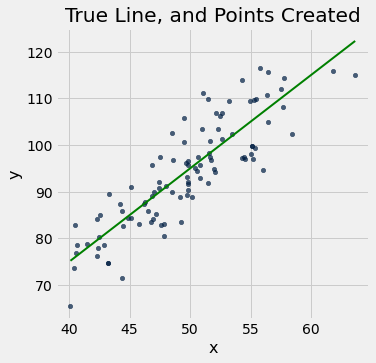

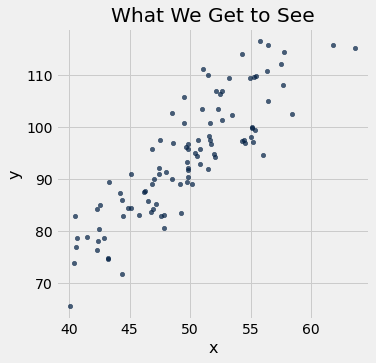

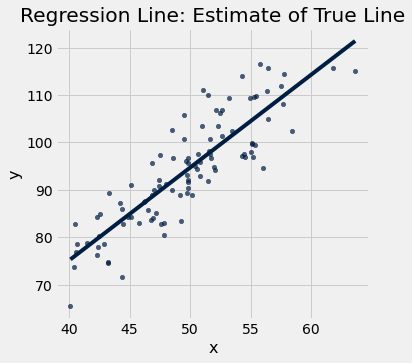

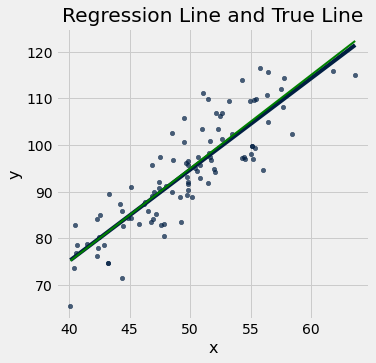

In [10]:
draw_and_compare(2, -5, 100)

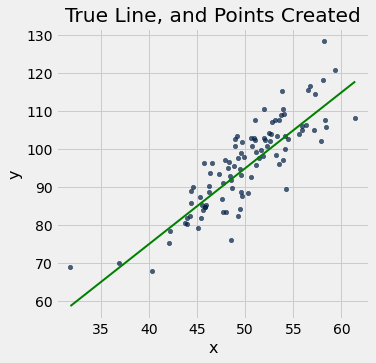

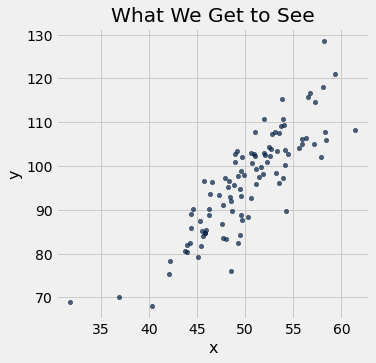

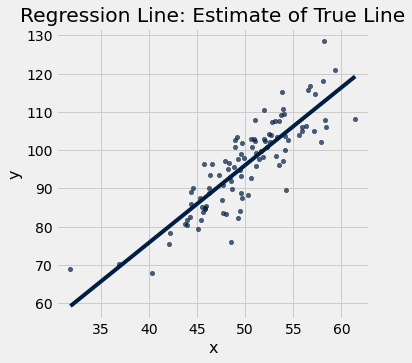

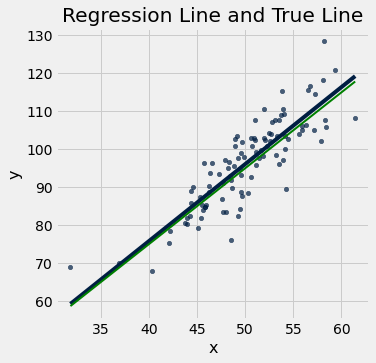

In [11]:
# 개수가 많을 수록 True Line과 비슷함
draw_and_compare(2, -5, 100)

**.**

## **Prediction**

In [35]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [36]:
# convert inches to cm
births.append_column('Maternal Height', births.apply(lambda x: np.round(x * 2.54, 1), 'Maternal Height'))
# convert ounces to kg
births.append_column('Birth Weight', births.apply(lambda x: np.round(x * 0.0283495, 2), 'Birth Weight'))
births.append_column('Maternal Pregnancy Weight', births.apply(lambda x: np.round(x * 0.0283495, 2), 'Maternal Pregnancy Weight'))
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
3.4,284,27,157.5,2.83,False
3.2,282,33,162.6,3.83,False
3.63,279,28,162.6,3.26,True
3.06,282,23,170.2,3.54,True
3.86,286,25,157.5,2.64,False
3.91,244,33,157.5,5.05,False
3.74,245,23,165.1,3.97,False
3.4,289,25,157.5,3.54,False
4.05,299,30,167.6,3.86,True
3.97,351,27,172.7,3.4,False


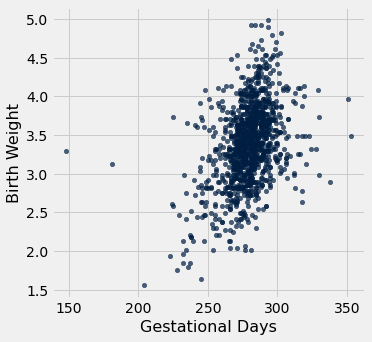

In [37]:
# 임신기간에 따른 초기 몸무게
births.scatter('Gestational Days', 'Birth Weight')

In [38]:
# Preterm and postterm pregnancy cutoffs, according to the CDC
# ~ 36 (preterm birth; 조기분만)
# 37 ~ 42 (term birth; 만삭분만)
# 43~ (post-term birth; 과숙분만)
37 * 7, 42 * 7

(259, 294)

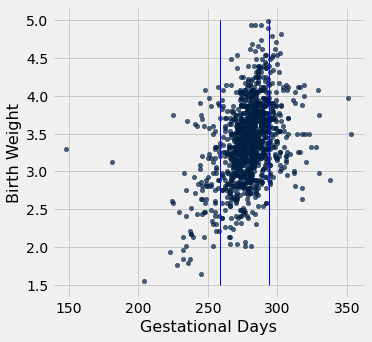

In [39]:
births.scatter('Gestational Days', 'Birth Weight')
plots.plot([259,259], [1.5, 5.0], color='b', lw=1)
plots.plot([294,294], [1.5, 5.0], color='b', lw=1)

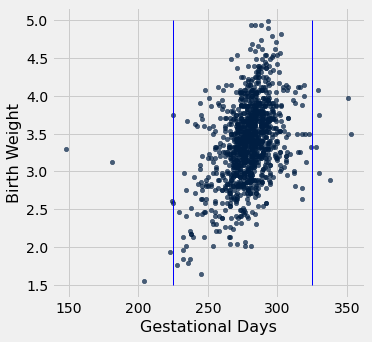

In [40]:
births.scatter('Gestational Days', 'Birth Weight')
plots.plot([225,225], [1.5, 5.0], color='b', lw=1)
plots.plot([325,325], [1.5, 5.0], color='b', lw=1)

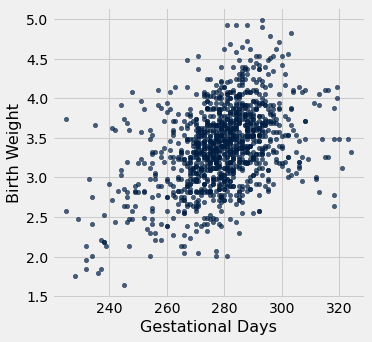

In [41]:
# for outlier removal
# 만삭 분만 기준 자르면 위에 파란 데이터 밖에 많은 영역 데이터가 무시됨
# 그래서 살짝 더 넓은 범위로 데이터를 표시할것임.
births = births.where('Gestational Days', are.between(225, 325))
births.scatter('Gestational Days', 'Birth Weight')

## **Suppose we assume the regression model**

In [42]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.42288816613401314

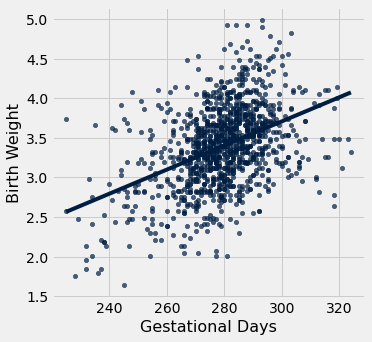

In [45]:
# Scatter 맨 뒤에 fit_line 하면 Regression line 그어줌
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

## **Prediction at a Given Value of x**

In [46]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [47]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

3.7085954781904777

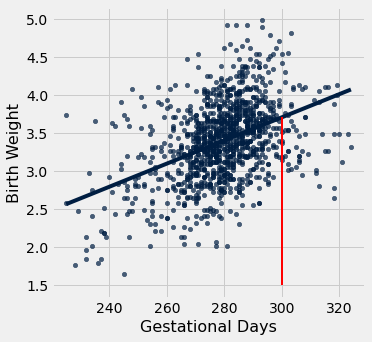

In [48]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [1.5, prediction_at_300], color='red', lw=2);

**.**

## **Bootstrapping the Sample**

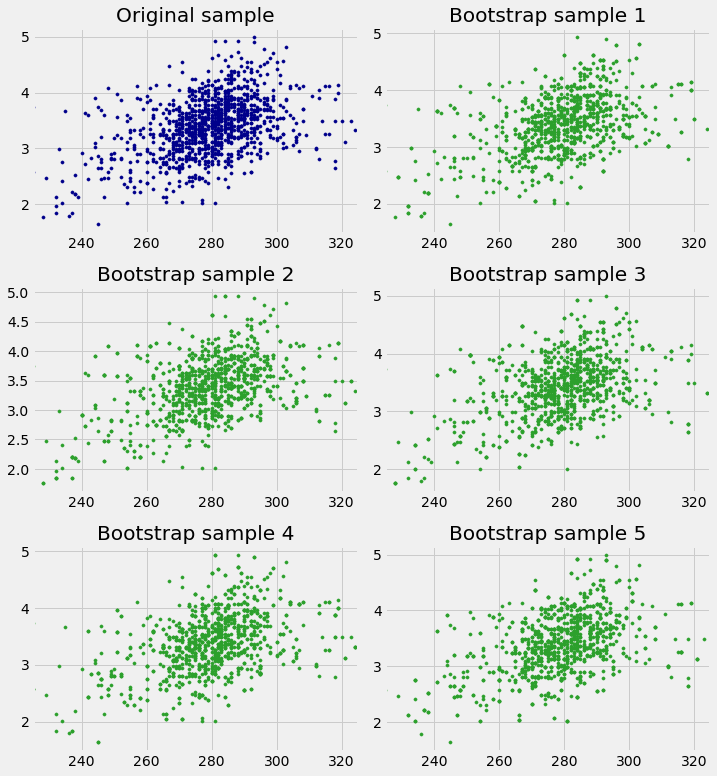

In [49]:
# You don't need to understand the plotting code in this cell,
# but you should understand the figure that comes out.

plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()

Predicted y from bootstramp sample was 3.73444384508
Predicted y from bootstramp sample was 3.66508838704
Predicted y from bootstramp sample was 3.66781741506
Predicted y from bootstramp sample was 3.71202483993


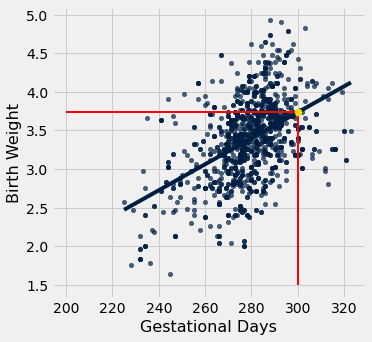

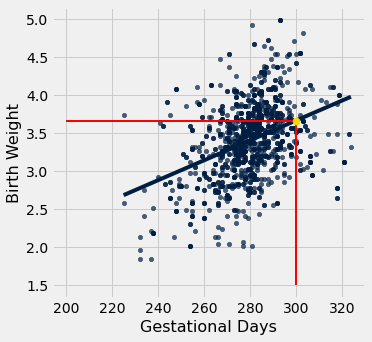

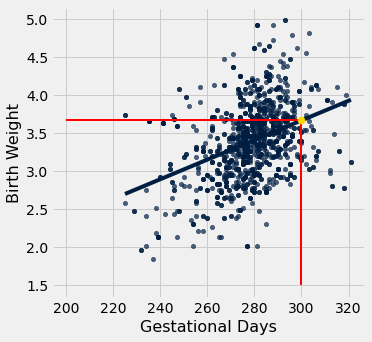

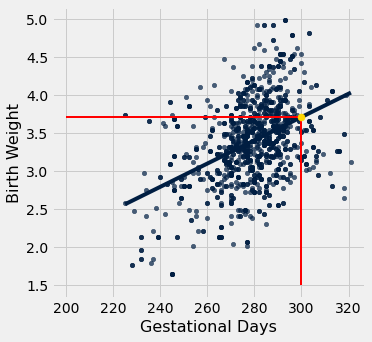

In [50]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [1.5, predicted_y], color='red', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='red', lw=2);

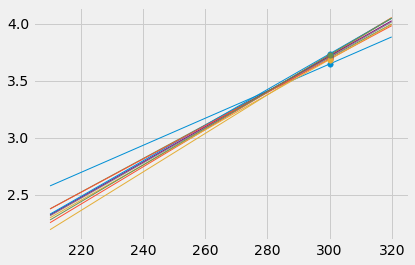

In [51]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

In [52]:
np.mean(births.column('Gestational Days')), np.mean(births.column('Birth Weight'))

(279.11015490533561, 3.3901204819277111)

In [55]:
# 계속 bootStrap해서 line을 구하고 line에 특정 점에 해당하는 prediction을 구해냄
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
lines


slope,intercept,at 291,at 300,at 309
0.014798,-0.735582,3.57063,3.70381,3.83699
0.0141368,-0.55106,3.56273,3.68997,3.8172
0.0156701,-0.981529,3.57847,3.7195,3.86053
0.0130915,-0.283492,3.52614,3.64396,3.76179
0.015731,-0.997016,3.58071,3.72229,3.86387
0.013734,-0.411268,3.58534,3.70895,3.83255
0.0150813,-0.811206,3.57745,3.71318,3.84891
0.0154422,-0.921802,3.57189,3.71087,3.84985
0.0147688,-0.741964,3.55576,3.68868,3.8216
0.0165124,-1.23161,3.57349,3.7221,3.87072


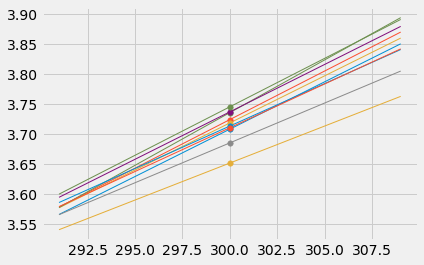

In [54]:
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## **Prediction Interval**

In [57]:
# 특정 newX에 대해 새롭게 fitting되는 직선에 대한 prediction 분포를 본다
def bootstrap_prediction(t, x, y, new_x, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the height of the true line at new_x, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    round_left = round(left, 3)
    round_right = round(right, 3)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line at x =', new_x)
    print(round_left, 'to', round_right, '( width =', round(right - left, 3), ')') 

Approximate 95%-confidence interval for height of true line at x = 300
3.654 to 3.763 ( width = 0.109 )


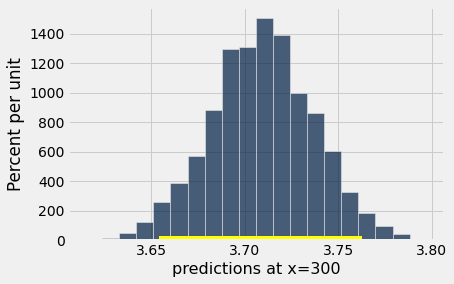

In [58]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

**.**

## **Predictions at Different Values of x**

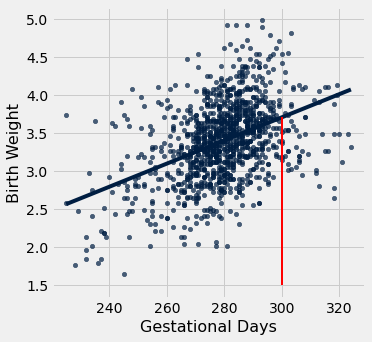

In [59]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [1.5, prediction_at_300], color='red', lw=2);

Approximate 95%-confidence interval for height of true line at x = 230
2.528 to 2.751 ( width = 0.222 )


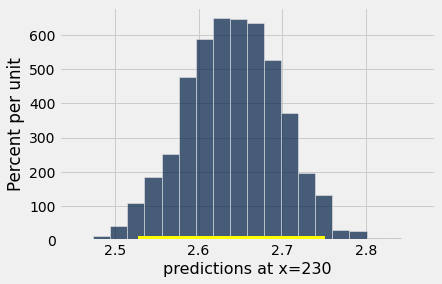

In [60]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 230)

Approximate 95%-confidence interval for height of true line at x = 280
3.376 to 3.431 ( width = 0.055 )


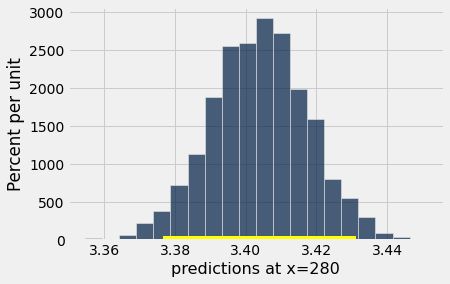

In [61]:
# mean에 가까운 280이 230보다 variation이 작게 나옴
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

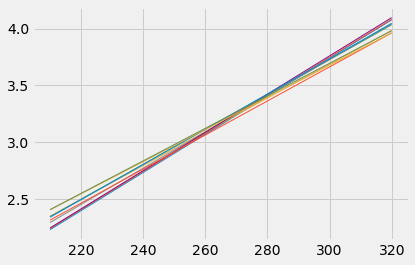

In [62]:
# No need to follow the code in this cell; just understand the graph

lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)

**.**

## **Inference for the True Slope**

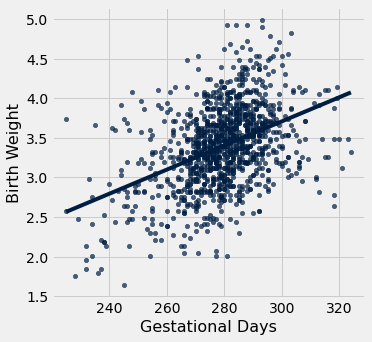

In [63]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [64]:
slope(births, 'Gestational Days', 'Birth Weight')

0.015245445565515978

In [65]:
def bootstrap_slope(t, x, y, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the slope of the true line, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    round_left = round(left, 3)
    round_right = round(right, 3)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results (no need to follow this code)
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', round(observed_slope, 3))
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(round_left, 'to', round_right)

Slope of regression line: 0.015
Approximate 95%-confidence interval for the slope of the true line:
0.013 to 0.018


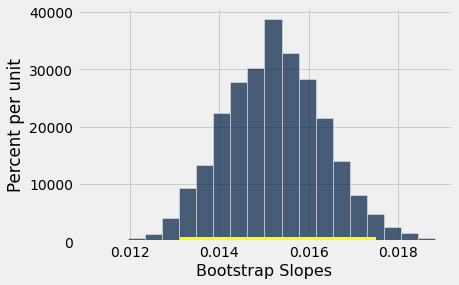

In [66]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight')

**.**

## **Rain on the Regression Parade**

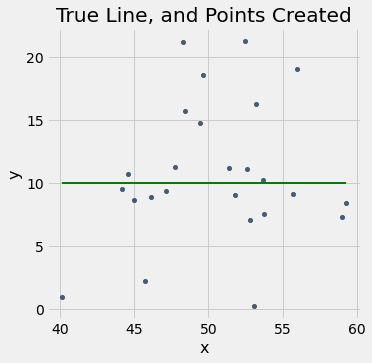

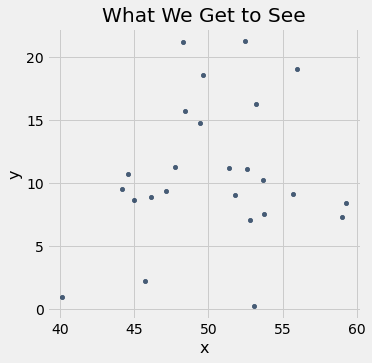

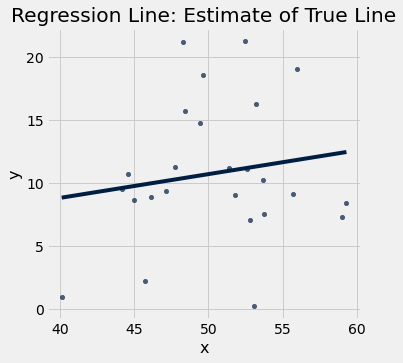

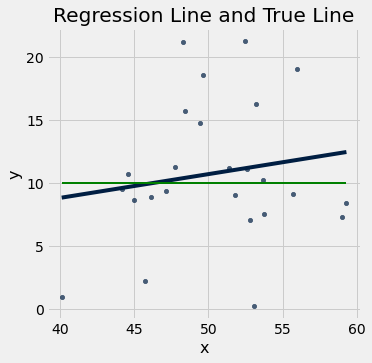

In [67]:
draw_and_compare(0, 10, 25)

**.**

### **Maternal Age and Birth Weight**

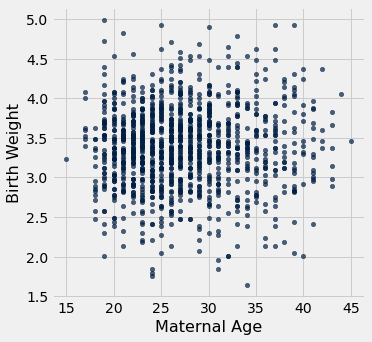

In [68]:
births.scatter('Maternal Age', 'Birth Weight')

In [69]:
slope(births, 'Maternal Age', 'Birth Weight')

0.0026829971565016132

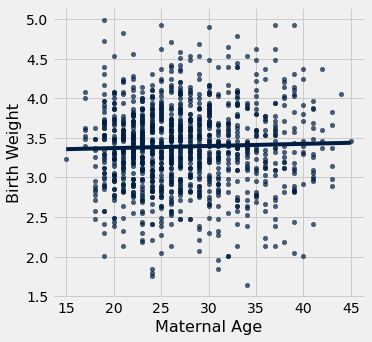

In [70]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

**Null:** Slope of true line is equal to 0.

**Alternative:** Slope of true line is not equal to 0.

Slope of regression line: 0.003
Approximate 95%-confidence interval for the slope of the true line:
-0.003 to 0.008


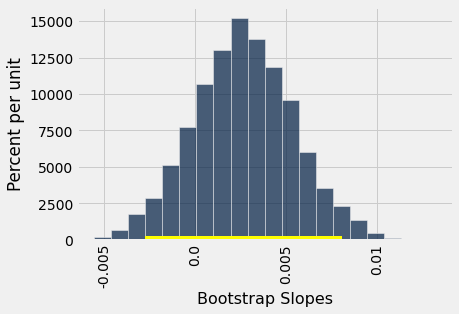

In [71]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight')